<a href="https://colab.research.google.com/github/christopherfr/trabajofinalml/blob/main/Trabajo_final_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importamos el dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls', header = 1)
data.drop('ID', axis = 1, inplace = True) # Nos deshacemos de la columna ID ya que no es importante
data.rename(columns = {'default payment next month': 'DEFAULT'}, inplace = True) # Nombre cambiado a uno más corto
data.rename(columns = {'PAY_0': 'PAY_1'}, inplace = True) # Corrección del nombre

In [2]:
data.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,100000,2,2,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
8,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,20000,1,3,2,35,-2,-2,-2,-2,-1,-1,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0


#Información acerca del dataset

Lista de variables por tipo

In [3]:
print('Variables categóricas nominales:')
print('  - SEX\n  - MARRIAGE\n  - EDUCATION') # EDUCATION no la tratamos como ordinal porque no se conoce qué incluye la categoría 'others'
print('Variables continuas:')
print('  - AGE\n  - PAY_1\n  - PAY_2\n  - PAY_3\n  - PAY_4\n  - PAY_5\n  - PAY_6\n  - BILL_AMT1\n  - BILL_AMT2\n  - BILL_AMT3\n  - BILL_AMT4\n  - BILL_AMT5\n  - BILL_AMT6\n  - PAY_AMT1\n  - PAY_AMT2\n  - PAY_AMT3\n  - PAY_AMT4\n  - PAY_AMT5\n  - PAY_AMT6')
print('Tenemos {} variables independientes en total.'.format(data.shape[1] - 1))
print('Variable target: DEFAULT')

Variables categóricas nominales:
  - SEX
  - MARRIAGE
  - EDUCATION
Variables continuas:
  - AGE
  - PAY_1
  - PAY_2
  - PAY_3
  - PAY_4
  - PAY_5
  - PAY_6
  - BILL_AMT1
  - BILL_AMT2
  - BILL_AMT3
  - BILL_AMT4
  - BILL_AMT5
  - BILL_AMT6
  - PAY_AMT1
  - PAY_AMT2
  - PAY_AMT3
  - PAY_AMT4
  - PAY_AMT5
  - PAY_AMT6
Tenemos 23 variables independientes en total.
Variable target: DEFAULT


Número de muestras que se usarán en los conjuntos de entrenamiento y prueba, como también la cantidad por cada clase.

In [4]:
m = len(data)
ratio_test = 0.1
q_test = int(round(m * ratio_test, 0))
q_train = m - q_test
print('Se tienen {} muestras en total. Un {}% se usará para la evaluación, es decir,\nse entrenarán los modelos con {} registros y con {} se evaluarán.'.format(m, ratio_test * 100, q_train, q_test))

import numpy as np
target_agrupado = data.groupby('DEFAULT')['DEFAULT'].count()
q_clases_target = np.array(target_agrupado.sort_index(ascending = True))
p_clases_target = q_clases_target / np.sum(q_clases_target) * 100
print('Para el entrenamiento un {}% será de la clase 0 (no default) y el otro {}% de la clase 1 (default).'.format(round(p_clases_target[0],1), round(p_clases_target[1],1)))

Se tienen 30000 muestras en total. Un 10.0% se usará para la evaluación, es decir,
se entrenarán los modelos con 27000 registros y con 3000 se evaluarán.
Para el entrenamiento un 77.9% será de la clase 0 (no default) y el otro 22.1% de la clase 1 (default).


Estadística descriptiva y visualización de los datos

##Descripción de las variables

En la siguiente tabla se muestran medidas estadísticas de las variables cuantitativas de la base de datos.

In [5]:
data.drop(['SEX','EDUCATION','MARRIAGE','DEFAULT'], axis = 1).describe()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


Descripción de la variable Edad

Se muestra un histograma que muestra la distribución de la población con respecto la variable `AGE` (edad).

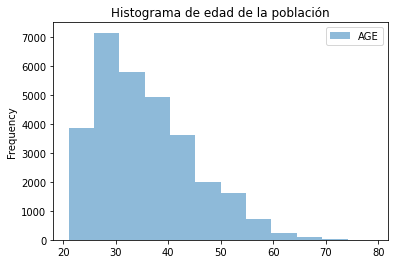

In [6]:
data.AGE.plot.hist(bins = 12, alpha=0.5)
plt.title('Histograma de edad de la población')
plt.legend()
plt.show()

Para las variables categóricas mostramos la cantidad de registros por cada categoría y el porcentaje que representan del total

Descripción de la variable Sexo

Se muestra una grafica de barras que muestra la distribucion de la población respecto a la variable `SEX` (sexo), donde:
*   1 = Male
*   2 = Female

In [7]:
enc = {1:'male', 2:'female'}
c = data.SEX.replace(enc).value_counts()
p = data.SEX.replace(enc).value_counts(normalize = True) * 100
pd.concat([c,p], axis=1, keys=['# registros', '% del total'])

,# registros,% del total
female,18112,60.373333
male,11888,39.626667


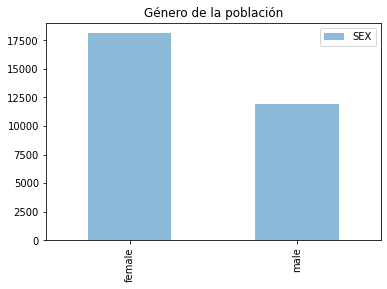

In [8]:
data.SEX.replace(enc).value_counts().plot(kind='bar',alpha=0.5)
plt.title('Género de la población')
plt.legend()
plt.show()

Descripción de la variable Educación

Se muestra una grafica de barras que muestra la distribucion de la población respecto a la variable `EDUCATION` (nivel educativo), donde:

*   1 = graduate school
*   2 = university
*   3 = high school
*   4 = others


In [9]:
enc = {1:'graduate school', 2:'university', 3:'high school', 4:'others', 5:'others', 6:'others', 0:'others'}
c = data.EDUCATION.replace(enc).value_counts()
p = data.EDUCATION.replace(enc).value_counts(normalize = True) * 100
pd.concat([c,p], axis=1, keys=['# registros', '% del total'])

,# registros,% del total
university,14030,46.766667
graduate school,10585,35.283333
high school,4917,16.390000
others,468,1.560000


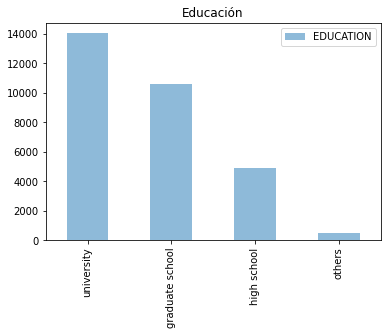

In [10]:
data.EDUCATION.replace(enc).value_counts().plot(kind = 'bar',alpha=0.5)
plt.title('Educación')
plt.legend()
plt.show()

Descripción de la variable Marriage

Se muestra una grafica de barras que muestra la distribucion de la población respecto a la variable `MARRIAGE` (estado civil), donde:
*   1 = married
*   2 = single
*   3 = others


In [11]:
enc = {1:'married', 2:'single', 3:'others', 0:'others'}
c = data.MARRIAGE.replace(enc).value_counts()
p = data.MARRIAGE.replace(enc).value_counts(normalize = True) * 100
pd.concat([c,p], axis=1, keys=['# registros', '% del total'])

,# registros,% del total
single,15964,53.213333
married,13659,45.530000
others,377,1.256667


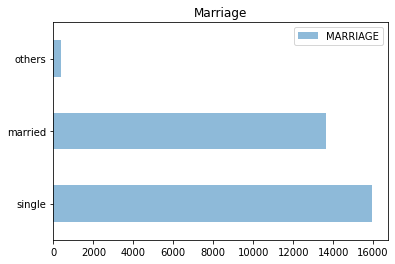

In [12]:
data.MARRIAGE.replace(enc).value_counts().plot(kind='barh',alpha=0.5)
plt.title('Marriage')
plt.legend()
plt.show()

#Modelamiento

##Preprocesamiento de la data

[De acuerdo al autor del dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/34608), en el caso de la variable `EDUCATION` se debe considerar a los valores 0, 4, 5 y 6 como de la clase `others`.

In [13]:
enc = {4:0, 5:0, 6:0}
data.EDUCATION.replace(enc, inplace = True)

De igual manera para la variable `MARRIAGE` a los valores 0 y 3.

In [14]:
enc = {3:0}
data.MARRIAGE.replace(enc, inplace = True)

La separación de train y test se ha realizado en un 10% para test y el 90% restante para train

In [15]:
from sklearn.model_selection import train_test_split

X = data.drop('DEFAULT', axis = 1)
y = data['DEFAULT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

##Algoritmo Random Forests

El primer clasificador que entrenamos es el Random Forests. A continuación creamos una nueva instancia de este clasificador y mostramos su performance con los hiperparámetros con valores por defecto. 

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

d_rfc = RandomForestClassifier(random_state = 42)
skf = StratifiedKFold(n_splits = 10)
d_rfc_res = cross_validate(d_rfc, X, y, cv = skf, return_train_score = True, scoring = ['accuracy','f1'])
print('Los valores por defecto de los hiperparámetros del algoritmo RF son:')
d_rfc.get_params()

Los valores por defecto de los hiperparámetros del algoritmo RF son:


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Y obtuvimos los siguientes resultados de exactitud:


In [17]:
print('La exactitud en el conjunto de train fue de {}'.format(np.mean(d_rfc_res['train_accuracy'])))
print('La exactitud en el conjunto de test fue de {}'.format(np.mean(d_rfc_res['test_accuracy'])))

La exactitud en el conjunto de train fue de 0.9993407407407406
La exactitud en el conjunto de test fue de 0.8155333333333333


Sin embargo, ya que tenemos clases desbalanceadas (`DEFAULT` = 1 es el 22%), la exactitud no es una buena métrica para medir nuestro dataset. Utilizaremos la métrica F1.

In [18]:
print('El puntaje F1 en el conjunto de train fue de {}'.format(np.mean(d_rfc_res['train_f1'])))
print('El puntaje F1 en el conjunto de test fue de {}'.format(np.mean(d_rfc_res['test_f1'])))

El puntaje F1 en el conjunto de train fue de 0.9985090765660714
El puntaje F1 en el conjunto de test fue de 0.4695483125961176


Notamos que obtuvimos un valor muy alto con el conjunto de entrenamiento, pero en la evaluación salió muy bajo, esto es un claro indicador de que el modelo tiene un sesgo muy alto (overfitting). 

Antes de empezar la búsqueda aleatoria de los mejores hiperparámetros, revisamos a partir de qué cantidad de árboles la métricas dejan de mejorar, con ese valor fijamos a `n_estimators` y ahorramos tiempo de procesamiento.

In [19]:
lista_q_arboles = np.around(np.linspace(2, 100, 30, endpoint = True)).astype(int)

train_accuracy = []
test_accuracy = []
train_f1 = []
test_f1 = []
for q_arboles in lista_q_arboles:
    i_rfc = RandomForestClassifier(random_state = 42, n_estimators = q_arboles)
    i_rfc_res = cross_validate(i_rfc, X, y, cv = skf, return_train_score = True, scoring = ['accuracy','f1'])
    train_accuracy.append(np.mean(i_rfc_res['train_accuracy']))
    test_accuracy.append(np.mean(i_rfc_res['test_accuracy']))
    train_f1.append(np.mean(i_rfc_res['train_f1'])) 
    test_f1.append(np.mean(i_rfc_res['test_f1']))

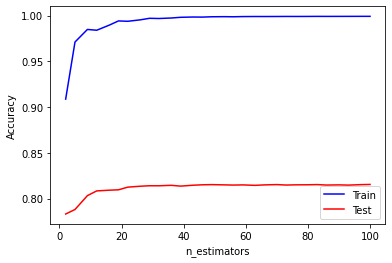

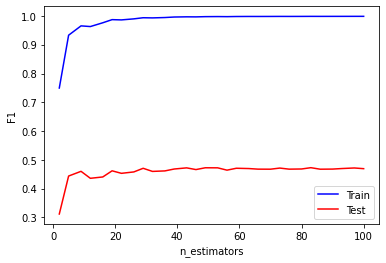

Notamos que a partir de los 40 árboles las métricas ya no se incrementan tanto. Usaremos 40 para el valor de n_estimators.


In [21]:
import matplotlib.pyplot as plt

plt.plot(lista_q_arboles, train_f1, 'b', label = 'Train')
plt.plot(lista_q_arboles, test_f1, 'r', label = 'Test')
plt.ylabel('F1')
plt.xlabel('n_estimators')
plt.legend(loc = 'lower right')
plt.show()

plt.plot(lista_q_arboles, train_accuracy, 'b', label = 'Train')
plt.plot(lista_q_arboles, test_accuracy, 'r', label = 'Test')
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.legend(loc = 'lower right')
plt.show()

print('Notamos que a partir de los 40 árboles las métricas ya no se incrementan tanto. Usaremos 40 para el valor de n_estimators.')

Con esto en mente, realizamos primero una búsqueda aleatoria para encontrar a los hiperparámetros que generen al mejor modelo.

In [22]:
from sklearn.model_selection import RandomizedSearchCV

r_rfc = RandomForestClassifier(random_state = 42, n_estimators = 40)

hp_dict = dict(max_depth = np.arange(5, 31),
               max_features = np.arange(1, X.shape[1] + 1))
               #min_samples_leaf = np.arange(0.001,0.101,0.001),
               #min_samples_split = np.arange(0.32,1.01,0.02),

rfc_rscv = RandomizedSearchCV(r_rfc,
                              param_distributions = hp_dict,
                              n_iter = 200,
                              return_train_score = True,
                              scoring = ['accuracy','f1'],
                              refit = 'f1',
                              cv = skf,
                              n_jobs = -1,
                              random_state = 42)
rfc_rscv.fit(X, y)

Estas son los hiperparámetros que dicha búsqueda ha encontrado:

In [23]:
rfc_rscv.best_params_

{'max_depth': 17, 'max_features': 12}

Que generan el modelo con el mejor puntaje:

In [38]:
rfc_rscv_res = rfc_rscv.cv_results_
print('Train F1: {}'.format(rfc_rscv_res['mean_train_f1'][rfc_rscv.best_index_]))
print('Test F1: {}'.format(rfc_rscv_res['mean_test_f1'][rfc_rscv.best_index_]))
print('Train accuracy: {}'.format(rfc_rscv_res['mean_train_accuracy'][rfc_rscv.best_index_]))
print('Test accuracy: {}'.format(rfc_rscv_res['mean_test_accuracy'][rfc_rscv.best_index_]))

Train F1: 0.788428514457695
Test F1: 0.4739257244734968
Train accuracy: 0.9215814814814814
Test accuracy: 0.8188333333333334


El modelo sigue mostrando indicios de overfitting.

In [ ]:
# QUE HACEMOS?

A partir de los hiperparámetros encontrados previamente, ejecutamos una búsqueda en grilla para encontrar con mayor precisión el mejor modelo.

In [36]:
while True:pass

KeyboardInterrupt: ignored